# **Transformer Interpretability applied on ViT for Food Recognition**

In [ ]:
# Importing all the needed libraries from the Trasformer Explainability repo

!git clone https://github.com/hila-chefer/Transformer-Explainability.git
import os
os.chdir(f'./Transformer-Explainability')
!pip install einops

# Other libs
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import zipfile
import pandas as pd

In [3]:
# connection to gdrive folder to import data/checkpoints
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
labels_food2k = pd.read_csv("/content/drive/MyDrive/TesiMagistrale/data/food2k_label.csv",encoding ="latin1",sep=";")

Mounted at /content/drive


In [4]:
# Saving food labels
CLS2IDX = pd.Series(labels_food2k.Category.values,index=labels_food2k.Index.values).to_dict()

# **ViT examples**

In [21]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

# Transformation pipeline applied to images
normalize = transforms.Normalize(mean=[0.482, 0.456, 0.406], std=[0.229, 0.221, 0.227])
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam


# visualize the heatmap or the segmentation on the image
def generate_visualization(original_image,attribution_generator, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    # if use_thresholding=True Otus thresholding is applied on the relavancy map and a segmentation is produced
    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1


    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return transformer_attribution,vis

def print_top_classes(predictions, **kwargs):
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Importing Vision Transformers models and pre-trained weights

In [22]:
# initialize ViT pretrained on Food-2k
model = vit_LRP(pretrained=True,num_classes= 2000).cuda()
model.eval()
attribution_generator = LRP(model)


# ViT trained on ImageNet
model_IN = vit_LRP(pretrained=True).cuda()
model_IN.eval()
attribution_generator_IN = LRP(model_IN)

In [24]:
# Loading Food2K weights

save_path = "/content/drive/MyDrive/TesiMagistrale/VIT/checkpoints"
model_name = "vit_base_finetune"

checkpoint = torch.load(save_path+f"/{model_name}.pt")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Importing a sample image and the GT mask

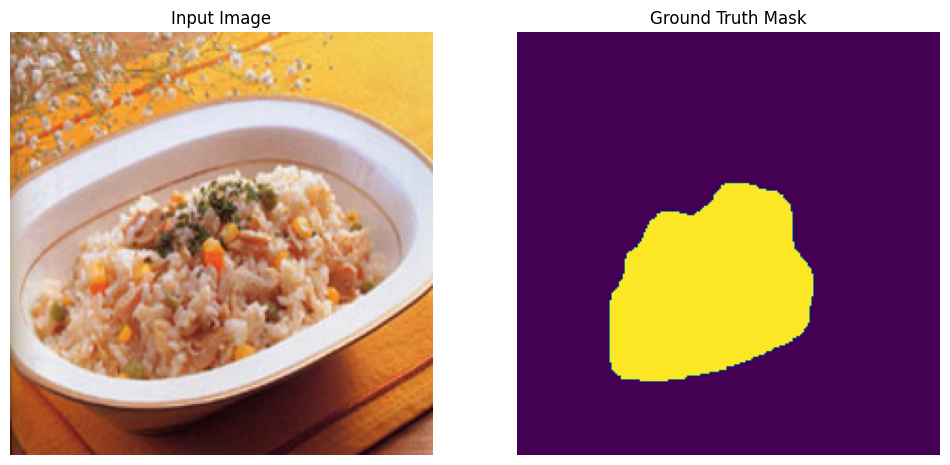

In [46]:
# A food image from UECFoodPix (the models have not been trained on this dataset)
image = Image.open('/content/drive/MyDrive/TesiMagistrale/data/UECFood/img/239.jpg').resize([224,224])

gt = np.array(Image.open('/content/drive/MyDrive/TesiMagistrale/data/UECFood/mask/239.png').resize([224,224]))[:,:,0]
gt = (gt > 0).astype(int)

plt.rcParams["figure.figsize"] = (12,6)
fig, axs = plt.subplots(1, 2)

axs[0].imshow(image.resize([224,224]));
axs[0].axis('off');
axs[0].title.set_text('Input Image');

axs[1].imshow(gt);
axs[1].axis('off');
axs[1].title.set_text('Ground Truth Mask');

Top 5 classes:
	1160 : Salmon fried rice   		value = 6.450	 prob = 28.6%
	255 : Pilaf               		value = 5.738	 prob = 14.1%
	1283 : Shrimp fried rice   		value = 5.358	 prob = 9.6%
	1811 : Fried rice with beef		value = 4.404	 prob = 3.7%
	1648 : Seafood paella      		value = 3.494	 prob = 1.5%


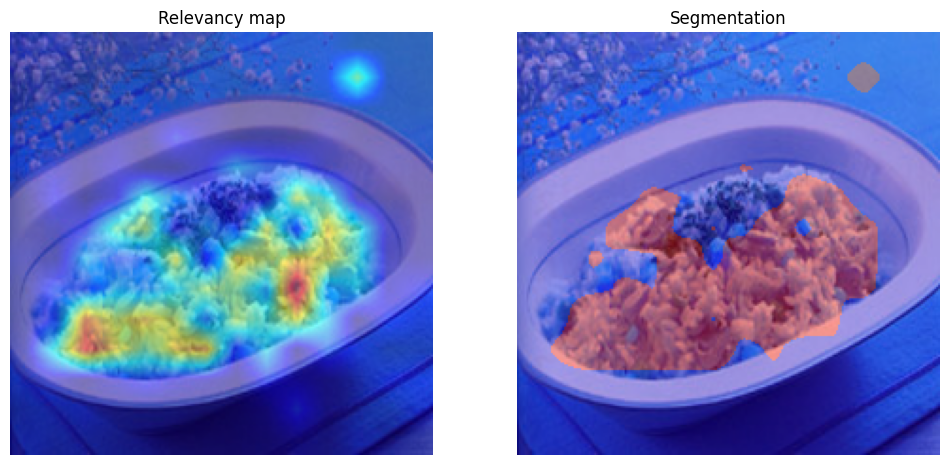

In [53]:
use_thresholding =  False
food_image = transform(image)

# Generating the relevancy map
output = model(food_image.unsqueeze(0).cuda())
_,map = generate_visualization(food_image,attribution_generator)

use_thresholding = True

# Generating the segmentation using Otsu's thresholding
_,map_t = generate_visualization(food_image,attribution_generator)

# Top 5 classes predicted by the model
print_top_classes(output)

# Plot
plt.rcParams["figure.figsize"] = (12,6)
fig, axs = plt.subplots(1, 2)

axs[0].imshow(map);
axs[0].axis('off');
axs[0].title.set_text('Relevancy map');

axs[1].imshow(map_t);
axs[1].axis('off');
axs[1].title.set_text('Segmentation');

Comparing the segmentation obtained by using a model pre-trained on Food2K and the same architecture pre-trained on ImageNet

In [51]:
# get image mask
use_thresholding = True

pred, map = generate_visualization(food_image,attribution_generator)
pred_IN, map_IN = generate_visualization(food_image,attribution_generator_IN)

# calculate intersection over union

def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def pa_score(y_true,y_pred):
    matches = (y_true == y_pred).sum()
    tot = y_true.shape[0]*y_true.shape[1]
    return matches/tot

def print_maps(image,pred,pred_2, map, map_2 ,gt):
    IoU = iou_score(gt, pred)
    IoU_2 = iou_score(gt, pred_2)
    PA = pa_score(gt, pred)
    PA_2 = pa_score(gt, pred_2)

    plt.rcParams["figure.figsize"] = (20,16)
    fig, axs = plt.subplots(1, 4)

    axs[0].imshow(image.resize([224,224]));
    axs[0].axis('off');
    axs[0].title.set_text('Input Image');

    axs[1].imshow(gt);
    axs[1].axis('off');
    axs[1].title.set_text('Ground Truth');

    axs[2].imshow(map);
    axs[2].axis('off');
    axs[2].title.set_text(f'Map Food-2k\n(IoU: {round(IoU,3)})\n(PA: {round(PA,3)})');

    axs[3].imshow(map_2);
    axs[3].axis('off');
    axs[3].title.set_text(f'Map ImageNet\n(IoU: {round(IoU_2,3)})\n(PA: {round(PA_2,3)})');



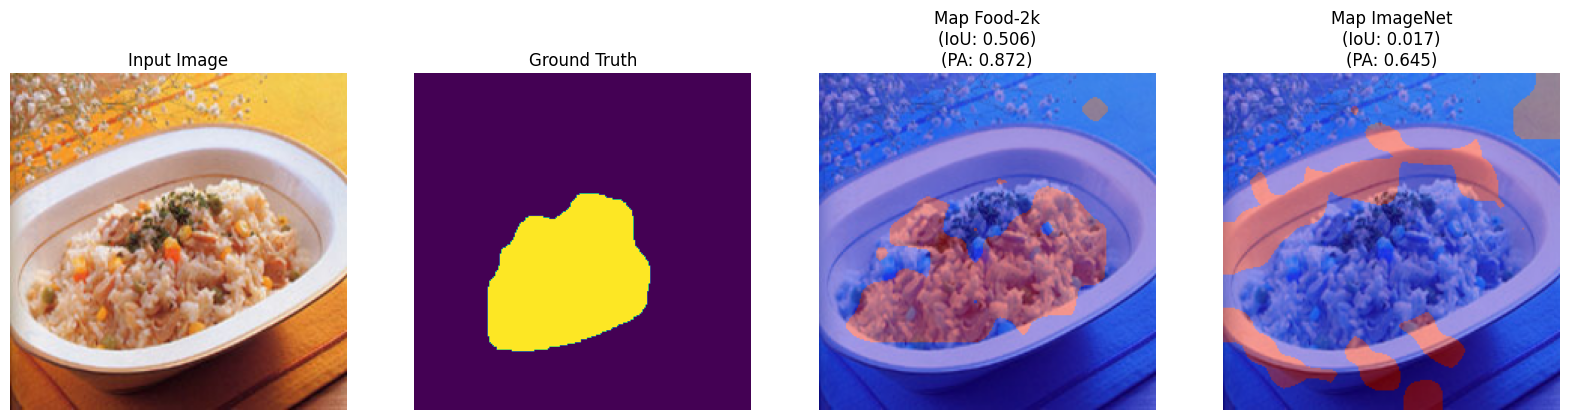

In [52]:
print_maps(image,pred,pred_IN,map,map_IN,gt)
plt.savefig("/content/example.pdf")

The map produced by the model pre-trained on Food2K actually emphasizes the food shown in the image, while the map produced by a model not trained on a food centered dataset is much less similar to the ground truth